In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor

import warnings
warnings.simplefilter(action="ignore")

In [2]:
df = pd.read_csv('NY property data.csv')

# 1. Remove Some Records That We’re Not Interested In

In [3]:
remove_list = df["OWNER"].value_counts().head(20).index.tolist() 
remove_list

['PARKCHESTER PRESERVAT',
 'PARKS AND RECREATION',
 'DCAS',
 'HOUSING PRESERVATION',
 'CITY OF NEW YORK',
 'DEPT OF ENVIRONMENTAL',
 'BOARD OF EDUCATION',
 'NEW YORK CITY HOUSING',
 'CNY/NYCTA',
 'NYC HOUSING PARTNERSH',
 'YORKVILLE TOWERS ASSO',
 'DEPARTMENT OF BUSINES',
 'DEPT OF TRANSPORTATIO',
 'MTA/LIRR',
 'PARCKHESTER PRESERVAT',
 'MH RESIDENTIAL 1, LLC',
 '434 M LLC',
 'LINCOLN PLAZA ASSOCIA',
 'DEUTSCHE BANK NATIONA',
 '561 11TH AVENUE TMG L']

In [4]:
remove_list.remove('YORKVILLE TOWERS ASSO') 
remove_list.remove('434 M LLC')
remove_list.remove('DEUTSCHE BANK NATIONA') 
remove_list.remove('561 11TH AVENUE TMG L') 
remove_list.append('UNITED STATES OF AMER') 
remove_list.append('U S GOVERNMENT OWNRD') 
remove_list.append('THE CITY OF NEW YORK') 
remove_list.append('NYS URBAN DEVELOPMENT') 
remove_list.append('NYS DEPT OF ENVIRONME') 
remove_list.append('CULTURAL AFFAIRS')
remove_list.append('DEPT OF GENERAL SERVI') 
remove_list.append('DEPT RE-CITY OF NY')
remove_list.append('NY STATE PUBLIC WORKS') 
remove_list.append('NYC DEPT OF HIGHWAYS') 
remove_list.append("NYC DEP'T OF HIGHWAYS") 
remove_list.append('CITY WIDE ADMINISTRAT') 
remove_list.append('DEPT OF PUBLIC WORKS') 
remove_list.append('NEW YORK CITY')
remove_list.append('THE PORT OFNY & NJ') 
remove_list.append('NYC DEPT OF PUB WORKS') 
remove_list.append('NEW YORK STATE DEPART') 
remove_list.append('CITY AND NON-CITY OWN')

In [5]:
property_data = df[-df['OWNER'].isin(remove_list)].reset_index(drop=True)
property_data.shape

(1046516, 32)

In [6]:
df.shape

(1070994, 32)

In [7]:
len(df) - len(property_data)

24478

# 2. Fill in the missing ZIPs

There are 2.8% null values.

In [8]:
missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

21537

In [9]:
for i in range(len(missing_zips)):
    if property_data.loc[missing_zips[i]+1,'ZIP'] == property_data.loc[missing_zips[i]-1,'ZIP']:
        property_data.loc[missing_zips[i],'ZIP'] = property_data.loc[missing_zips[i]-1,'ZIP']

In [10]:
missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

10114

In [11]:
for i in range(len(missing_zips)):
    property_data.loc[missing_zips[i],'ZIP'] = property_data.loc[missing_zips[i]-1,'ZIP']

In [12]:
missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

0

# 3. Fill in missing FULLVAL, AVLAND, AVTOT

They are 100% populated but have 1.21% of 0.

In [13]:
temp = property_data[property_data['FULLVAL']!=0]
mean_fullval = temp.groupby('TAXCLASS')['FULLVAL'].mean()
mean_fullval

TAXCLASS
1     5.700050e+05
1A    3.352942e+05
1B    3.741718e+05
1C    7.615359e+05
1D    2.233614e+07
2     8.005832e+05
2A    8.639066e+05
2B    1.254525e+06
2C    7.723556e+05
3     8.510005e+04
4     2.713604e+06
Name: FULLVAL, dtype: float64

In [14]:
temp = property_data[property_data['AVLAND']!=0]
mean_avland = temp.groupby('TAXCLASS')['AVLAND'].mean()

In [15]:
temp = property_data[property_data['AVTOT']!=0]
mean_avtot = temp.groupby('TAXCLASS')['AVTOT'].mean()

In [16]:
taxclass = property_data['TAXCLASS'].unique()
taxclass

array(['4', '2', '2A', '2C', '3', '2B', '1', '1A', '1C', '1B', '1D'],
      dtype=object)

In [17]:
for i in taxclass:
    property_data.loc[(property_data['TAXCLASS'] == i) & (property_data['FULLVAL'] == 0),'FULLVAL'] = mean_fullval[i]
    property_data.loc[(property_data['TAXCLASS'] == i) & (property_data['AVLAND'] == 0),'AVLAND'] = mean_avland[i]
    property_data.loc[(property_data['TAXCLASS'] == i) & (property_data['AVTOT'] == 0),'AVTOT'] = mean_avtot[i]

# 4. Fill in missing STORIES

STORIES is 94.75% populated, but has no zeros.

In [18]:
temp = property_data[property_data['STORIES'].isnull()]
len(temp)

43684

In [19]:
temp['TAXCLASS'].value_counts()

1B    19000
4     17768
2      3434
3      2398
1       877
2C      138
2B       34
2A       30
1A        5
Name: TAXCLASS, dtype: int64

In [20]:
mean_stories = property_data.groupby('TAXCLASS')['STORIES'].mean()
mean_stories

TAXCLASS
1      2.111631
1A     1.656867
1B     4.000000
1C     3.052748
1D     1.068966
2     16.310549
2A     2.844032
2B     4.001635
2C     4.745047
3      1.000000
4      5.517525
Name: STORIES, dtype: float64

In [21]:
for i in taxclass:
    property_data.loc[(property_data['TAXCLASS'] == i) & (property_data['STORIES'].isnull()),'STORIES'] = mean_stories[i]

# 5. Fill in LTFRONT, LTDEPTH, BLDFRONT, BLDDEPTH

They don't have null values but have values such as 0 and 1 that don't make sense.

In [22]:
temp = property_data[property_data['LTFRONT'] > 1]
mean_LTFRONT = temp.groupby('TAXCLASS')['LTFRONT'].mean()

In [23]:
temp = property_data[property_data['LTDEPTH'] > 1]
mean_LTDEPTH = temp.groupby('TAXCLASS')['LTDEPTH'].mean()

In [24]:
temp = property_data[property_data['BLDFRONT'] > 1]
mean_BLDFRONT = temp.groupby('TAXCLASS')['BLDFRONT'].mean()

In [25]:
temp = property_data[property_data['BLDDEPTH'] > 1]
mean_BLDDEPTH = temp.groupby('TAXCLASS')['BLDDEPTH'].mean()

In [26]:
for i in taxclass:
    property_data.loc[(property_data['TAXCLASS'] == i) & (property_data['LTFRONT'] <= 1),'LTFRONT'] = mean_LTFRONT[i]
    property_data.loc[(property_data['TAXCLASS'] == i) & (property_data['LTDEPTH'] <= 1),'LTDEPTH'] = mean_LTDEPTH[i]
    property_data.loc[(property_data['TAXCLASS'] == i) & (property_data['BLDFRONT'] <= 1),'BLDFRONT'] = mean_BLDFRONT[i]
    property_data.loc[(property_data['TAXCLASS'] == i) & (property_data['BLDDEPTH'] <= 1),'BLDDEPTH'] = mean_BLDDEPTH[i]

# 6. Make the Variables

In [27]:
data = property_data.copy()

In [28]:
data['ZIP'] = data['ZIP'].astype(str)
data['ZIP3'] = data['ZIP'].str[:3]

In [29]:
data['ltsize'] = data['LTFRONT'] * data['LTDEPTH']
data['bldsize'] = data['BLDFRONT'] * data['BLDDEPTH']
data['bldvol'] = data['bldsize'] * data['STORIES']

In [30]:
data['r1'] = data['FULLVAL'] / data['ltsize'] 
data['r2'] = data['FULLVAL'] / data['bldsize'] 
data['r3'] = data['FULLVAL'] / data['bldvol'] 
data['r4'] = data['AVLAND'] / data['ltsize']
data['r5'] = data['AVLAND'] / data['bldsize'] 
data['r6'] = data['AVLAND']/ data['bldvol'] 
data['r7'] = data['AVTOT'] / data['ltsize']
data['r8'] = data['AVTOT'] / data['bldsize'] 
data['r9'] = data['AVTOT'] / data['bldvol']

In [31]:
rvars = data.columns[36:] # 9 columns
for var in rvars:
    data[var + 'inv'] = 1 / data[var]

In [32]:
rvars = data.columns[36:] # 18 columns
zip5_mean = data.groupby('ZIP')[rvars].mean()
zip3_mean = data.groupby('ZIP3')[rvars].mean()
taxclass_mean = data.groupby('TAXCLASS')[rvars].mean()
borough_mean = data.groupby('BORO')[rvars].mean()

In [33]:
data = data.join(zip5_mean, on = 'ZIP', rsuffix = '_zip5')
data = data.join(zip3_mean, on = 'ZIP3', rsuffix = '_zip3')
data = data.join(taxclass_mean, on = 'TAXCLASS', rsuffix = '_taxclass')
data = data.join(borough_mean, on = 'BORO', rsuffix = '_boro')

In [34]:
rsuffix = ['_zip5','_zip3','_taxclass','_boro']
for var in rvars:
    for r in rsuffix:
        data[var + r] = data[var] / data[var + r]

In [35]:
rvars = data.columns[36:] # 90 columns
stats = data[rvars].describe().transpose()
#stats.to_csv('stats_on_vars.csv')

In [36]:
stats

,count,mean,std,min,25%,50%,75%,max
r1,1046516.0,213.503808,528.509868,3.920017e-04,76.375353,152.916667,243.200000,135680.195265
r2,1046516.0,536.237504,1015.743970,7.470782e-04,212.235545,500.000000,683.891491,310742.524961
r3,1046516.0,243.931653,486.583927,8.983394e-05,82.741261,239.102564,336.257310,227500.000000
r4,1046516.0,10.453704,69.427805,8.333333e-06,2.356020,4.598000,7.225959,22032.314558
r5,1046516.0,22.710592,373.449262,2.096125e-04,6.215246,14.983333,20.287152,334842.138488
...,...,...,...,...,...,...,...,...
r5inv_boro,1046516.0,1.000000,19.450371,4.203214e-06,0.058377,0.080627,0.150912,3631.168214
r6inv_boro,1046516.0,1.000000,29.382102,4.480289e-07,0.013570,0.024501,0.055710,3229.769331
r7inv_boro,1046516.0,1.000000,62.640625,9.752543e-06,0.147765,0.303232,0.502178,59345.351446
r8inv_boro,1046516.0,1.000000,24.510354,4.381270e-06,0.084663,0.129699,0.207992,13798.782934


# 7. Reduce dimensions via PCA

In [37]:
save_record = data['RECORD']
data = data.drop(columns = data.columns[:36])

In [38]:
data_zs = (data - data.mean()) / data.std()
data_zs.describe()

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1inv,...,r9_boro,r1inv_boro,r2inv_boro,r3inv_boro,r4inv_boro,r5inv_boro,r6inv_boro,r7inv_boro,r8inv_boro,r9inv_boro
count,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,...,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06
mean,-4.987863e-14,-4.120539e-14,-4.213792e-15,-1.192801e-14,-1.523930e-15,6.895732e-16,-4.875373e-14,-2.858347e-15,-1.090882e-14,-5.867553e-15,...,2.007761e-15,1.238156e-15,-2.314096e-15,-6.055043e-16,-2.560382e-15,-7.841169e-15,2.958956e-15,3.110794e-16,-2.496063e-15,3.008599e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.039724e-01,-5.279251e-01,-5.013145e-01,-1.505693e-01,-6.081250e-02,-5.747917e-02,-1.328478e-01,-5.410804e-02,-5.868685e-02,-1.970110e-02,...,-6.391883e-02,-1.759386e-02,-2.268715e-02,-2.076027e-02,-1.960607e-02,-5.141268e-02,-3.403431e-02,-1.596393e-02,-4.079891e-02,-4.659194e-02
25%,-2.594624e-01,-3.189799e-01,-3.312695e-01,-1.166346e-01,-4.417025e-02,-4.582967e-02,-1.066404e-01,-3.531737e-02,-3.673350e-02,-1.897378e-02,...,-3.880826e-02,-1.673407e-02,-2.201533e-02,-2.061962e-02,-1.797203e-02,-4.841156e-02,-3.357250e-02,-1.360515e-02,-3.734491e-02,-4.505767e-02
50%,-1.146377e-01,-3.567583e-02,-9.924473e-03,-8.434234e-02,-2.069159e-02,-1.627775e-02,-9.028477e-02,-2.510215e-02,-1.948221e-02,-1.854359e-02,...,-2.062950e-02,-1.627134e-02,-2.169611e-02,-2.053040e-02,-1.682510e-02,-4.726764e-02,-3.320045e-02,-1.112325e-02,-3.550747e-02,-4.412737e-02
75%,5.618853e-02,1.453654e-01,1.897425e-01,-4.649066e-02,-6.489343e-03,4.138601e-04,-6.574734e-02,-1.540155e-02,-4.344369e-03,-1.738226e-02,...,-3.517677e-03,-1.503698e-02,-2.064109e-02,-2.021859e-02,-1.448689e-02,-4.365410e-02,-3.213827e-02,-7.947278e-03,-3.231318e-02,-4.248983e-02
max,2.563182e+02,3.053981e+02,4.670439e+02,3.171908e+02,8.965594e+02,6.432875e+02,3.142499e+02,9.373068e+02,8.985515e+02,4.520239e+02,...,8.910096e+02,6.645625e+02,7.831392e+02,8.003317e+02,9.464894e+02,1.866375e+02,1.098890e+02,9.473780e+02,5.629369e+02,4.959927e+02


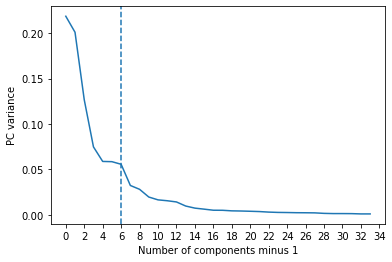

In [39]:
pca = PCA(n_components = .99, svd_solver = 'full')
pca.fit(data_zs)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components minus 1')
plt.ylabel('PC variance')
plt.xticks(np.arange(0, 36, step=2))
plt.axvline(x=6, linestyle='--')

(0.0, 1.0)

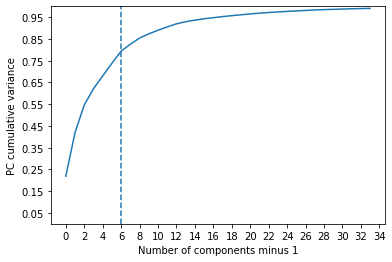

In [40]:
plt.xlabel('Number of components minus 1')
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylabel('PC cumulative variance')
plt.yticks(np.arange(0.05, 1.1, step=.1))
plt.xticks(np.arange(0, 36, step=2))
plt.axvline(x=6, linestyle='--')
plt.ylim(0,1)

In [41]:
pca = PCA(n_components = 7, svd_solver = 'full')
princ_comps = pca.fit_transform(data_zs)
pca.n_components_

7

In [42]:
data_pca = pd.DataFrame(princ_comps)
data_pca_zs = (data_pca - data_pca.mean()) / data_pca.std()
data_pca_zs.describe()

,0,1,2,3,4,5,6
count,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06
mean,-3.674173e-17,-7.219090e-17,-2.099865e-16,8.099080e-17,-1.622185e-16,2.384340e-16,1.823951e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-5.821852e+01,-8.891024e-02,-2.399561e+02,-2.940419e+02,-3.364301e+02,-2.238167e+02,-2.821592e+02
25%,-1.033812e-01,-5.119081e-02,-1.555735e-01,-2.735354e-03,-8.111186e-02,-1.327432e-01,-8.786648e-02
50%,-1.722495e-02,-4.480539e-02,-6.019241e-02,2.607797e-03,4.683933e-03,-1.151279e-02,-3.336247e-02
75%,4.002710e-02,-3.567613e-02,3.200520e-02,9.450733e-03,5.391875e-02,2.843840e-01,1.234761e-02
max,6.972967e+02,4.059682e+02,3.235610e+02,8.135371e+02,4.420073e+02,5.187210e+02,4.111819e+02


# 8. Create fraud scores

In [43]:
p1 = 2
oop1 = 1/p1
score1 = (((data_pca_zs).abs()**p1).sum(axis=1))**oop1

(0.1, 2088568.0377569061)

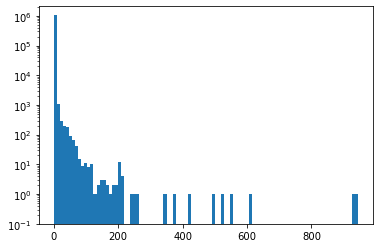

In [44]:
plt.hist(score1, bins=100)
plt.yscale('log')
plt.ylim(ymin=.1)

In [45]:
NNmodel = MLPRegressor(hidden_layer_sizes=(3),activation='logistic',max_iter=50,random_state=1)
NNmodel.fit(data_pca_zs,data_pca_zs)
pca_out = NNmodel.predict(data_pca_zs)
error = pca_out - data_pca_zs
p2 = 2
oop2 = 1/p2
score2 = ((error.abs()**p2).sum(axis=1))**oop2

(0.1, 2091020.427275921)

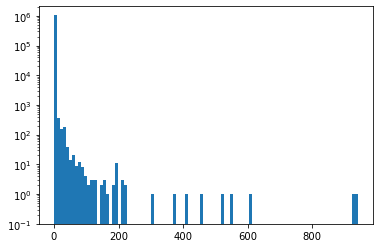

In [46]:
plt.hist(score2, bins=100)
plt.yscale('log')
plt.ylim(ymin=.1)

In [47]:
scores = pd.DataFrame({'score1':score1, 'score2':score2})
scores['RECORD'] = save_record
scores['score1 rank'] = scores['score1'].rank()
scores['score2 rank'] = scores['score2'].rank()
scores['final'] = (.5*scores['score1 rank'] + .5*scores['score2 rank'])
scores

,score1,score2,RECORD,score1 rank,score2 rank,final
0,3.174454,0.722283,1,1033650.0,1022732.0,1028191.0
1,69.917070,43.001728,2,1046396.0,1046392.0,1046394.0
2,0.277335,0.079038,9,574151.0,487154.0,530652.5
3,0.476098,0.087728,10,754258.0,526218.0,640238.0
4,1.086139,0.211946,11,1004035.0,917356.0,960695.5
...,...,...,...,...,...,...
1046511,0.213344,0.055351,1070990,463420.0,332347.0,397883.5
1046512,0.294623,0.135485,1070991,594409.0,667019.0,630714.0
1046513,0.290824,0.086791,1070992,590194.0,522345.0,556269.5
1046514,0.357997,0.105422,1070993,654853.0,588337.0,621595.0


<AxesSubplot:xlabel='final', ylabel='Density'>

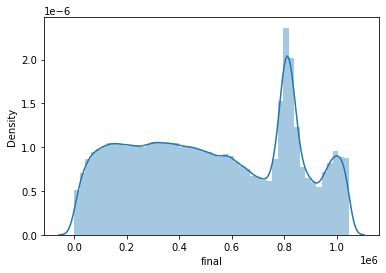

In [48]:
sns.distplot(scores['final'])

In [49]:
scores = scores.merge(df,on ='RECORD',how='left')
scores.head()

,score1,score2,RECORD,score1 rank,score2 rank,final,BBLE,BORO,BLOCK,LOT,...,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
0,3.174454,0.722283,1,1033650.0,1022732.0,1028191.0,1000010101,1,1,101,...,0,0,3775500.0,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR
1,69.917070,43.001728,2,1046396.0,1046392.0,1046394.0,1000010201,1,1,201,...,0,0,11111400.0,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR
2,0.277335,0.079038,9,574151.0,487154.0,530652.5,1000041001,1,4,1001,...,0,0,636093.0,2049290.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
3,0.476098,0.087728,10,754258.0,526218.0,640238.0,1000041002,1,4,1002,...,0,0,919276.0,2961617.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
4,1.086139,0.211946,11,1004035.0,917356.0,960695.5,1000041003,1,4,1003,...,0,0,967500.0,5483912.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR


In [50]:
col_names = list(df.columns)
col_names.extend(['score1 rank','score2 rank','final'])
scores = scores[col_names]
scores_sorted = scores.sort_values(by=['final','RECORD'], ascending=[False,True])
scores_sorted.head()

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,score1 rank,score2 rank,final
898718,917942,4142600001,4,14260,1,NaN,"LOGAN PROPERTY, INC.",T1,4,4910,...,4.501180e+09,1.644454e+09,4.501180e+09,NaN,FINAL,2010/11,AC-TR,1046516.0,1046516.0,1046516.0
975385,996722,5029220125,5,2922,125,NaN,IMPERIAL COURT HOMEOW,V0,1B,300,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1046515.0,1046515.0,1046515.0
674960,691986,4039160200,4,3916,200,NaN,TITAN SOUNDVIEW POINT,Z7,4,0,...,3.000000e+00,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1046514.0,1046514.0,1046514.0
935946,956520,5006590012,5,659,12,NaN,TROMPETA RIZALINA,A1,1,25,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1046513.0,1046513.0,1046513.0
701584,718883,4051251107,4,5125,1107,NaN,GARDEN VIEW LTD,R4,2,0,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1046512.0,1046512.0,1046512.0


In [55]:
scores_sorted[:30].to_csv('scores.csv')